In [43]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import cv2
from torchvision import transforms
from sklearn.metrics import accuracy_score
import torchvision
from torchvision.datasets.folder import default_loader
from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from pytorch_lightning import LightningDataModule
from torch.utils.data import Subset, DataLoader, Dataset
import matplotlib.pyplot as plt


In [40]:
from src.dataset import ImageDataModule
from src.baseline import BaselineClf

In [41]:
data_path = Path("../data/images")

In [42]:
img1 = cv2.imread("../data/images/no/1 no.jpeg")
img2 = cv2.imread("../data/images/no/2 no.jpeg")


In [11]:
class SIFTImageFolder(ImageFolder):
    def __init__(self, root, loader=default_loader, is_valid_file=None):
        super(SIFTImageFolder, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        self.sift = cv2.SIFT_create()

    def __getitem__(self, index):
        image_path, target = self.samples[index]
        im = cv2.imread(image_path)
        kp, desc = self.sift.detectAndCompute(im, None)
        features = desc[0].reshape(16, 8)
        #im_nonoise = cv2.medianBlur(im, 3)
        # you need to convert img from np.array to torch.tensor
        # this has to be done CAREFULLY!
        sample = torchvision.transforms.ToTensor()(features)
        return sample, target


In [12]:
class SIFTImageDataModule(LightningDataModule):
    def __init__(self, batch_size=32, num_workers=4, transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        # Define data transform
        train_transform = []
        if self.transform is not None:
            train_transform+=self.transform
        train_transform += [
                transforms.Resize(128),             # resize shortest side to 128 pixels
                transforms.CenterCrop(128),         # crop longest side to 128 pixels at center
                transforms.ToTensor()               # convert PIL image to tensor
        ]
        train_transform = transforms.Compose(train_transform)
        test_transform=transforms.Compose([
                transforms.Resize(128),             # resize shortest side to 128 pixels
                transforms.CenterCrop(128),         # crop longest side to 128 pixels at center
                transforms.ToTensor()               # convert PIL image to tensor
        ])
        
        # Initialize train/test sets
        data_path = Path("../data/images")
        train_dataset = SIFTImageFolder(data_path)
        test_dataset = SIFTImageFolder(data_path)
        classes = train_dataset.find_classes(data_path)[1]
        print(f"Loaded samples into dataset with label 'no'={classes['no']} and 'yes'={classes['yes']}")
        
        # Split dataset into train/test sets and stratify over labels to balance datasets with set seed 
        # DO NOT CHANGE THE SEED
        generator = torch.Generator().manual_seed(390397)
        train_len = int(0.8*len(train_dataset))
        test_len = int((len(train_dataset)-train_len)/2)
        train_dataset = random_split(
            dataset=train_dataset, 
            lengths=[train_len, test_len, test_len],
            generator=generator)[0]
        val_dataset, test_dataset = random_split(
            dataset=test_dataset, 
            lengths=[train_len, test_len, test_len],
            generator=generator)[1:]
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [13]:
class SIFTBaselineClf(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False), # 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), # 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), 
            nn.Linear(512, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch 
        # Get predictions
        out = self(images)         
        # Get loss        
        loss = F.cross_entropy(out, labels) 
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        # Get predictions
        out = self(images)                    
        # Get loss
        loss = F.cross_entropy(out, labels)   
        # Get accuracy
        _, preds = torch.max(out, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        print("Accuracy: ", acc)          
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        print("test")
        images, labels = batch 
        # Get predictions
        out = self(images)                    
        # Get loss
        loss = F.cross_entropy(out, labels)   
        # Get accuracy
        _, preds = torch.max(out, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())          
        return {'val_loss': loss, 'val_acc': acc}

In [14]:
train_loader = SIFTImageDataModule()
trainer = pl.Trainer(accelerator="gpu", devices=1)
model = SIFTBaselineClf()

C:\Users\Julia\miniconda3\envs\ml4h\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, train_dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.6 M 
-------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.426     Total estimated model params size (MB)


Loaded samples into dataset with label 'no'=0 and 'yes'=1
Sanity Checking: 0it [00:00, ?it/s]

TypeError: cannot pickle 'cv2.SIFT' object

In [32]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
matches = bf.match(descriptor1, descriptor2)

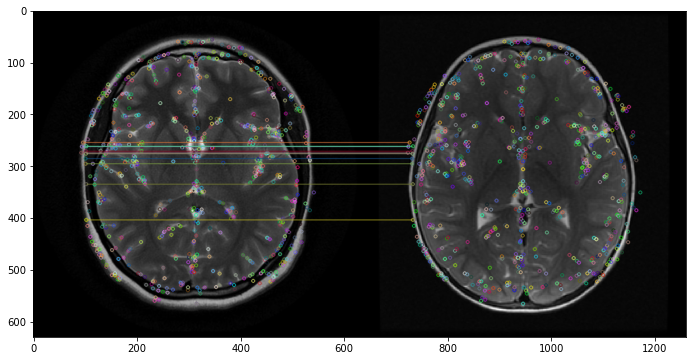

In [35]:
matches = sorted(matches, key = lambda x:x.distance)
N_MATCHES = 10

match_img = cv2.drawMatches(
    img1, keypoints1,
    img2, keypoints2,
    matches[:N_MATCHES], img1.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

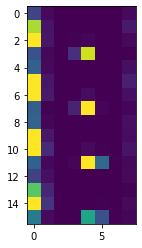

In [43]:
plt.imshow(descriptor1[0].reshape(16, 8), interpolation='none')

In [47]:
transform = [transforms.RandomRotation(90), transforms.RandomHorizontalFlip()]
train_loader = ImageDataModule(transform=transform)
trainer = pl.Trainer()
model = BaselineClf()

TypeError: 'ImageFolder' object is not an iterator

In [54]:
img = cv2.imread("../data/images/no/4 no.jpg")
sift = cv2.SIFT_create()

In [55]:
kp, desc = sift.detectAndCompute(img, None)

In [56]:
desc.shape

(232, 128)

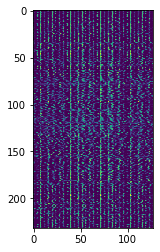

In [57]:
plt.imshow(desc, interpolation='none')

In [58]:
desc.shape

(232, 128)

In [76]:
import os
import shutil


In [78]:
data_folder = Path("../data/SIFT_features")
if os.path.exists("../data/SIFT_features"):
    shutil.rmtree("../data/SIFT_features")

os.mkdirs("../data/SIFT_features", "../data/SIFT_features/yes", "../data/SIFT_features/no")


